# first check that synthetically made image data given shape  2525 x 2525 x 3

In [1]:
!nvidia-smi

Wed May 20 09:03:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   39C    P0    52W / 300W |      1MiB / 16128MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# validate synthetically created image size is 2525x2525x3 
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
c=random.sample(os.listdir('/workspace/Data'),1)
random_img=random.sample(os.listdir('/workspace/Data/'+c[0]),1)
test=plt.imread('/workspace/Data/'+c[0]+'/'+random_img[0])
print(test.shape)

(2525, 2525, 3)


In [3]:
## make label so it is easier to visualize and do plotting 
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
tf.compat.v1.enable_eager_execution()

label2num={'notHappy':0,'Happy':1,'others':2}
num2label=dict([(b,a) for (a,b) in label2num.items()])
device_id=0


---------------------------------------------------------------------------------------------------------------

# === next we add flip+ **rotate** + resize to 224x224x3  and create a new pipeline named Opt3Pipeline ===
## run through notebook = **resize2big_image.ipynb** to create corresponding director file= **bigimgs_path.txt**

In [4]:
from __future__ import division
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path




class HybridPipe(Pipeline):
    def __init__(self, img_file_list,num_shards, shard_id, batch_size, num_threads, device_id, pipelined = True, exec_async = True):
        super(HybridPipe, self).__init__(batch_size, num_threads, device_id, seed = 12, exec_pipelined=pipelined, exec_async=exec_async)
        self.input = ops.FileReader(file_root = "", num_shards=num_shards, shard_id=shard_id, file_list=img_file_list,random_shuffle = True, initial_fill = 21)
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.rrc = ops.RandomResizedCrop(
                device="gpu",
                size=(800,800),
                random_area=[0.8, 0.8]
            )
        self.resize = ops.Resize(device="gpu", resize_x=224, resize_y=224)
        self.augmentations = {}
        # input is sampled randomly for output pixel's neighbourhood
        self.augmentations["jitter"] = ops.Jitter(device = "gpu")
        # transforms sampling coordinates to produce wavy patterns
        self.augmentations["water"] = ops.Water(device = "gpu")
        # applies fisheye distortion
        self.augmentations["shpere"] = ops.Sphere(device = "gpu")
        
        # applies affine transform
        self.augmentations["warpaffine"] = ops.WarpAffine(device = "gpu", matrix = [1.0, 0.8, 0.0, 0.0, 1.2, 0.0],
                                                 interp_type = types.INTERP_LINEAR) 
        # twists colors of the image
        self.augmentations["hsv"] = ops.Hsv(device = "gpu", hue = 45., saturation = 0.2)
        # places the image on a larger canvas
        self.augmentations["paste"] = ops.Paste(device = "gpu", ratio = 2., fill_value = (55, 155, 155),
                                            paste_x = .1, paste_y = .7)
        # param resizes the image so that the shorter edge is exactly 400px long
        #self.augmentations["resize"] = ops.Resize(device = "gpu", resize_shorter = 96)
        # param flips the image 
        self.augmentations["flip_h"] = ops.Flip(device = "gpu", vertical = 0, horizontal = 1)
        self.augmentations["flip_v"] = ops.Flip(device = "gpu", vertical = 1, horizontal = 0)
        # rotates the image, enlarging the canvas
        self.augmentations["rotate"] = ops.Rotate(device = "gpu", angle = 30, interp_type = types.INTERP_LINEAR, fill_value = 0)
        self.resize = ops.Resize(device="gpu", resize_x=224, resize_y=224)
        self.iter = 3

    def define_graph(self):
        self.jpegs, self.labels = self.input()
        images = self.decode(self.jpegs)
        images = self.rrc(images)
        images = self.resize(images)
        n = len(self.augmentations)
        outputs = [images for _ in range(n+1)]
        aug_list = list(self.augmentations.values())
        # outputs[0] is the original cropped image
        for i in range(n):
            outputs[i+1] = aug_list[i](outputs[i+1])
        outputs[-1]=self.resize(outputs[-1])
        return [self.labels]+outputs

    def iter_setup(self):
        pass

In [5]:
batch_size = 2

pipe = HybridPipe("bigimgs_path.txt",  2, 0,batch_size, 2,  0)
pipe.build()

In [6]:
pipe_out = pipe.run()
print(pipe_out,len(pipe_out)) 

(<nvidia.dali.backend_impl.TensorListCPU object at 0x7efc6b251030>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc559851f0>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc55985228>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc55985260>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc55985298>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc559852d0>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc55985308>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc55985340>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc55985378>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc559853b0>, <nvidia.dali.backend_impl.TensorListGPU object at 0x7efc559853e8>) 11


In [7]:
[np.array(pipe_out[i].as_cpu().as_tensor()).shape for i in range(1,11)]

[(2, 224, 224, 3),
 (2, 224, 224, 3),
 (2, 224, 224, 3),
 (2, 224, 224, 3),
 (2, 224, 224, 3),
 (2, 224, 224, 3),
 (2, 448, 448, 3),
 (2, 224, 224, 3),
 (2, 224, 224, 3),
 (2, 224, 224, 3)]

In [8]:
# put the images back to cpu so we can plot to exam whether the augmentation is done properly
images_out = pipe_out[1].as_cpu()
labels_out = pipe_out[0]
print(type(images_out),type(labels_out))
images_list = np.array(images_out.as_tensor())
labels_list = np.array(labels_out.as_tensor())
print(type(images_list),type(labels_list))

<class 'nvidia.dali.backend_impl.TensorListCPU'> <class 'nvidia.dali.backend_impl.TensorListCPU'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
import numpy as np

images_list.shape, labels_list.shape , labels_list[:3]

((2, 224, 224, 3), (2, 1), array([[1],
        [2]], dtype=int32))

---------------------------------the original image's label is : Happy ---------------------------------



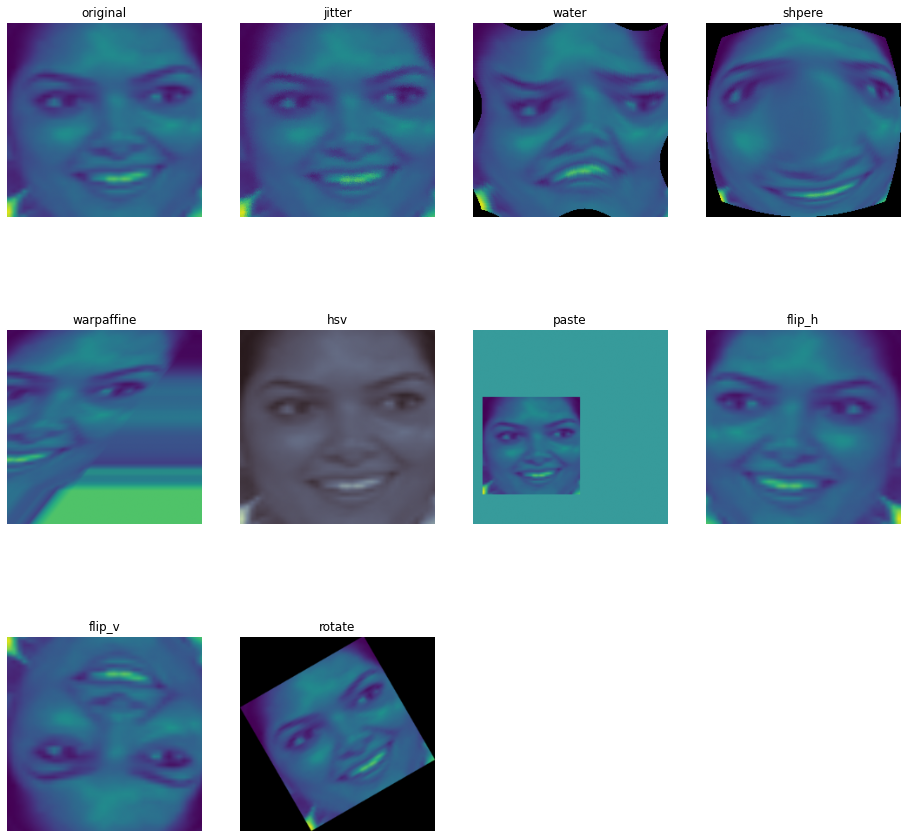

In [10]:
import matplotlib.gridspec as gridspec
import random
# get label from pipeline output 
label2num={'notHappy':0,'Happy':1,'others':2}
num2label=dict([(b,a) for (a,b) in label2num.items()])
device_id=0
label_map = num2label
labels = np.array(pipe_out[0].as_tensor())

len_outputs = len(pipe_out) - 1
augmentations = ["original"] + list(pipe.augmentations.keys())
imgs=[np.array(pipe_out[i].as_cpu().as_tensor()) for i in range(1,11)]
fig = plt.figure(figsize = (16,16))
columns = 4
rows = int(math.ceil(len_outputs / columns))
gs = gridspec.GridSpec(rows, columns)
rn=random.randint(0,batch_size-1) # randomly choose an image from the 32 images in the batch
print("---------------------------------the original image's label is : {} ---------------------------------\n".format(label_map[labels[rn][0]]))
cnt=0
for i in range(len_outputs):
    plt.subplot(gs[i])
    plt.axis("off")
    plt.title(augmentations[i])
    
    img_chw = imgs[i][rn] 
    #print(img_chw.shape)
    plt.imshow((img_chw)/255.0)
    